In [1]:
import torch
import torch.nn as nn 
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Make sure to update where the MNIST dataset is being downloaded to
DATA_PATH = "~/Research/data" 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_data = datasets.CIFAR10(
    root=DATA_PATH,            
    train=True,            
    download=True,          
    transform=transform    
)
test_data = datasets.CIFAR10(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=transform 
)

train_dataloader = DataLoader(training_data,    # our dataset
                              batch_size=64,    # batch size
                              shuffle=True      # shuffling the data
                            )
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model_unif_init = NeuralNetwork() 

In [3]:
model_zero_init = NeuralNetwork()

for name, param in model_zero_init.named_parameters(): 
    param.data = torch.zeros_like(param.data)
    
model_gauss_init = NeuralNetwork() 

for name, param in model_gauss_init.named_parameters(): 
    param.data = torch.randn_like(param.data)  

In [4]:
# create helper function to show distribution of model parameters 
import matplotlib.pyplot as plt 
import numpy as np 

def param_hist(model:nn.Module, model_name:str) -> None: 
    res = [] 
    for name, param in model.named_parameters(): 
        res += torch.flatten(param.data).tolist()
        
    plt.hist(res, bins=np.linspace(min(res) -0.1, max(res) + 0.1, 100))
    plt.title(f"Histogram of Parameter Distribution of {model_name}")
    plt.show() 

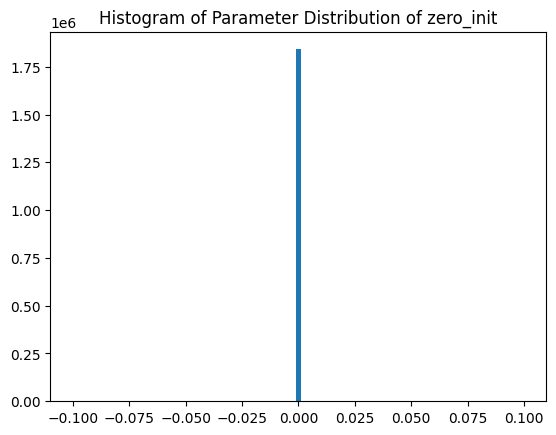

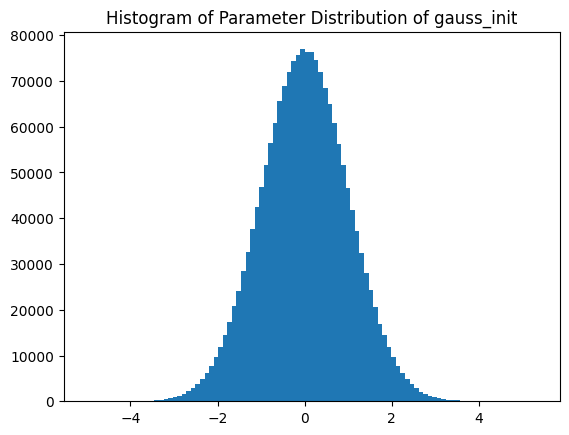

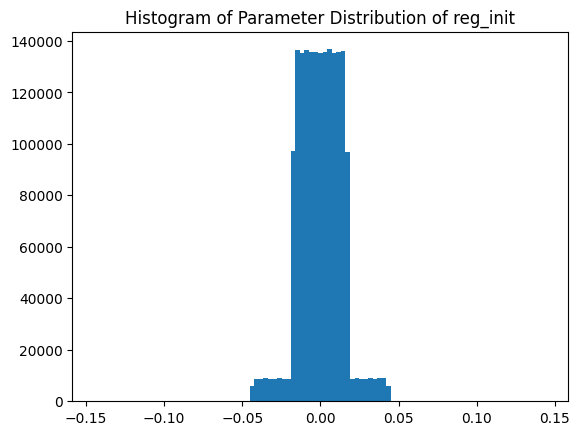

In [5]:
param_hist(model_zero_init, "zero_init") 
param_hist(model_gauss_init, "gauss_init")
param_hist(model_unif_init, "reg_init")

In [6]:
device = "cuda"

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [8]:
accs = [[], [], []] 

for i, model in enumerate([model_unif_init, model_gauss_init, model_zero_init]): 
     
    model = model.cuda()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(),     # which parameters to optimize
        lr=1e-3,                 # learning rate 
        momentum=0.9
    )
    
    epochs = 15
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        acc = test(test_dataloader, model, loss_fn)
        accs[i].append(acc)
   
    print(accs) 

Epoch 1
-------------------------------
loss: 2.306829  [   64/50000]
loss: 2.236031  [ 6464/50000]
loss: 2.221076  [12864/50000]
loss: 2.042069  [19264/50000]
loss: 2.000013  [25664/50000]
loss: 1.923817  [32064/50000]
loss: 1.906660  [38464/50000]
loss: 1.850209  [44864/50000]
Test Error: 
 Accuracy: 35.5%, Avg loss: 1.834386 

Epoch 2
-------------------------------
loss: 1.837965  [   64/50000]
loss: 1.827877  [ 6464/50000]
loss: 1.621506  [12864/50000]
loss: 1.733264  [19264/50000]
loss: 1.705072  [25664/50000]
loss: 2.015937  [32064/50000]
loss: 1.752681  [38464/50000]
loss: 1.870839  [44864/50000]
Test Error: 
 Accuracy: 41.2%, Avg loss: 1.673012 

Epoch 3
-------------------------------
loss: 1.608791  [   64/50000]
loss: 1.603927  [ 6464/50000]
loss: 1.618158  [12864/50000]
loss: 1.602984  [19264/50000]
loss: 1.605762  [25664/50000]
loss: 1.638919  [32064/50000]
loss: 1.780837  [38464/50000]
loss: 1.534678  [44864/50000]
Test Error: 
 Accuracy: 44.9%, Avg loss: 1.589315 

Epoc

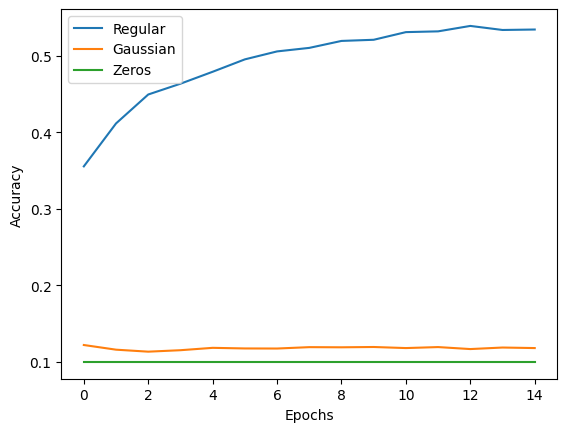

In [10]:
import matplotlib.pyplot as plt 

plt.plot(accs[0], label="Regular") 
plt.plot(accs[1], label="Gaussian") 
plt.plot(accs[2], label="Zeros") 
plt.ylabel("Accuracy") 
plt.xlabel("Epochs")
plt.legend()
plt.show()
    